# Machine Learning With Android and Arduino

## Introduction

###   I collected data on three different surfaces: carpet, cobble stone, and ceramic tile. The goal of the project is to design a classification scheme that will identify the surface based on readings from the tri-axial accel. This project imports the data from the Accel Plot and Arduino project (http://www.instructables.com/id/Realtime-MPU-6050A0-Data-Logging-With-Arduino-and-/), performs some exploratory analysis, and uses decision trees to classify the data.

## Instrumentation Setup

### I fabricated a shield for the Arduino Uno that included the HC-05 Bluetooth module and the MPU-6050 accelerometer/gyrometer sensors. For this project only the accelerometers of the MPU-6050 are used. The figure below shows the shield layout.

![title](img/ShieldLayout_sm.jpg)

### I mounted the shield to a small remote-controlled (RC) car, as shown in the photo below. This was a safe platform for me to test the data collection and operate the Android data collection device. Channel 1 is the x-axis accelerometer and is positive when the car moves backwards, channel 2 is the y-axis accelerometer and is positive when the car moves towards the drive, and channel 3 is the z-axis accelerometer and is positive when the car moves upwards.

![title](img/ChannelAxisMap.jpg)

## Data Collection

### I used the Accel Plot (https://play.google.com/store/apps/details?id=com.dairyroadsolutions.accelplot&hl=en) application to display and collect the data. Each file is 1 minute long (15,000 samples). I made two different runs on each surface. The image below shows the three different surfaces.


![title](img/surfaces.JPG)

# Notebook Setup

This line is required to display the plots in the notebook

In [1]:
%matplotlib inline

# Definitions and Functions
### This value is defined in the Arduino code and documented in "Bluetooth.java" in the application

In [2]:
D_SAMPLING_FREQUENCY = 250.0

### Pull in the libraries and define the functions we will be using

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')

### This function pulls in the data for each channel from Accel Plot data files

In [4]:
def getChannelData(iChannel, strTestCase):
    cwd = os.getcwd()
    cwd = cwd+'\\TrainingData\\'+strTestCase

    f = []
    for (dirpath, dirnames, filenames) in os.walk(cwd):
        f.extend(filenames)
        break
        
    strFileSearch = 'Trace0' + str(iChannel)
    strFiles = filter(lambda x:strFileSearch in x, f)
    
    
    for idx in range(0, len(strFiles)):
        fh = open(cwd+'\\'+strFiles[idx], 'rb')
        # read the data into numpy
        if(idx==0):
            xEnd = np.fromfile(fh, dtype=('>f'))
        else:
            xEnd = np.append(x, np.fromfile(fh, dtype=('>f')))
        fh.close()
    
    # We have to switch the underlying NumPy array to native system
    # Great write up at: http://pandas.pydata.org/pandas-docs/stable/gotchas.html. 
    # If you don't do this you get an error: ValueError: Big-endian buffer not supported on little-endian compiler
    x = xEnd.byteswap().newbyteorder()
    
    return (x,strFiles)

### This function pads the ends of a data with first valid samples at each end

In [5]:
def padDataFrame(dfData, idx):

    for column in dfData:
        fTemp =  float(dfData[column].iloc[idx:(idx+1)])
        dfData[column].iloc[0:idx] = fTemp
        fTemp = float(dfData[column].iloc[-idx-1:-idx])
        dfData[column].iloc[-idx:] = fTemp
    
    return dfData

### This function calculates a rolling (moving) mean for the data frame. Pad with the first valid sample.

In [6]:
def getDataFrameRM(dfData, window_size):
    
    # These lines add the rolling average
    dfDataRM = dfData.rolling(window=window_size, center=True).mean()
    dfDataRM.columns = dfDataRM.columns+'_rm'
    
    # zero-indexed, no need to add 1
    idx = int(window_size/2)

    # Pad with the closest good value
    dfDataRM = padDataFrame(dfDataRM, idx)

    return dfDataRM

### This function implements a clever way of calculating the rolling RMS values, from: http://stackoverflow.com/questions/8245687/numpy-root-mean-squared-rms-smoothing-of-a-signal

In [7]:
def getRMS(data, window_size):
    data2 = np.power(data,2)
    window = np.ones(window_size)/float(window_size)
    return np.sqrt(np.convolve(data2, window, 'same'))

### This function returns a new data frame with rolling RMS values

In [8]:
def getDataFrameRMS(dfData, window_size):
    
    dfRMS = dfData.copy(deep=True)
    
    for column in dfData:
        data = np.array(dfData[column])
        dfRMS[column] = getRMS(data, window_size)
        
    dfRMS.columns = dfData.columns+'_rms'
    
    # zero-indexed, no need to add 1
    idx = int(window_size/2)
    
    dfRMS = padDataFrame(dfRMS, window_size)
        
    return dfRMS

### This function calculates peak values for each column in the entire data frame. The signal processing model includes: remove the mean, rectify the signal, restore the mean, and keep the rolling maximum values.

In [9]:
def getDataFramePk(dfData, window_size):
    
    # We want to rectify about the mean
    mn = dfData.mean()
    dfPk = dfData-mn
    dfPk = dfPk.abs()
    dfPk = dfPk+mn
    
    # Rolling maximum
    dfPk = dfPk.rolling(window = window_size, center=True).max()
    
    # correct the column names    
    dfPk.columns = dfData.columns+'_pk'
    
    # zero-indexed, no need to add 1
    idx = int(window_size/2)
    
    # Pad with the closest good value
    dfPk = padDataFrame(dfPk, idx)
        
    return dfPk

### This function calculates the crest factor (ratio of peak to rms) for each columns in a data frame

In [10]:
def getDataFrameCrest(dfData, dfDataPk, dfDataRMS):
    
    dfCrest = dfDataPk.copy(deep=True)
    
    iCol = len(dfDataPk.columns)
    
    for idxCol in range(0,iCol):
        dataPk = np.array(dfDataPk.ix[:,idxCol])
        dataRMS = np.array(dfDataRMS.ix[:,idxCol])
        dfCrest.ix[:,idxCol] = np.divide(dataPk, dataRMS)
        
    dfCrest.columns = dfData.columns+'_cr'
        
    return dfCrest


### This function pulls the arrays from the data file function into a single data frame and addes the extracted values

In [11]:
def getDataAsFrame(strTestCase):

    # Read the data in
    (x1,strFiles1) = getChannelData(1,strFolder)
    (x2,strFiles2) = getChannelData(2,strFolder)
    (x3,strFiles3) = getChannelData(3,strFolder)
    (x4,strFiles4) = getChannelData(4,strFolder)
    t = np.divide(range(0,len(x1)),D_SAMPLING_FREQUENCY)

    # Construct the data frame
    dfData = pd.DataFrame(data={('t'):t,
                                ('Ch1'):x1, 
                                ('Ch2'):x2, 
                                ('Ch3'):x3, 
                                ('Ch4'):x4,
                                'Surface':strTestCase})
    
    data_cols = [col for col in dfData.columns if 'Ch' in col]


    # Rolling average
    window_size = 15
    dfDataRM = getDataFrameRM(dfData[data_cols], window_size)

    # Rolling RMS
    window_size = 11
    dfDataRMS = getDataFrameRMS(dfData[data_cols], window_size)

    # RMS of the rolling mean
    window_size = 11
    dfDataRM_RMS = getDataFrameRMS(dfDataRM, window_size)

    # Rolling peak value
    window_size = 15
    dfDataPk = getDataFramePk(dfData[data_cols], window_size)

    # Peak value of the rolling mean
    window_size = 15
    dfDataRM_Pk = getDataFramePk(dfDataRM, window_size)

    # Crest value
    dfDataCrest = getDataFrameCrest(dfData[data_cols], dfDataPk, dfDataRMS)

    # Aggregate the dataframes
    dfData = pd.concat([dfData, dfDataRM, dfDataRMS, dfDataRM_RMS, dfDataPk, dfDataRM_Pk, dfDataCrest],
                       axis=1, join_axes = [dfData.index])
    
    return dfData

### This function appends one dataframe to another

In [12]:
def appendDataAsFrame(strTestCase, dfData):
    dfNew = getDataAsFrame(strTestCase)
    dfDataOut = dfData.append(dfNew)
    dfDataOut = dfDataOut.reset_index(drop=True)

    return dfDataOut

### This function plots out the signal features against the raw data

In [13]:
def plotFeatures(dfDataPlot, strColName):
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.subplots_adjust(wspace=.5, hspace=0.5)
    
    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_rm'], 
                     ax=axes[0,0], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName+" Rolling Mean")

    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_rms'], 
                     ax=axes[0,1], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName+" RMS")

    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_pk'], 
                     ax=axes[1,0], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName+" Peak")

    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_rm_pk'], 
                     ax=axes[1,1], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName+" Peak of Rolling Mean")

### This function plots the timebase data in the data frame

In [14]:
def plotFolder(dfDataPlot):
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.subplots_adjust(wspace=.5, hspace=0.5)
    
    strColName = 'Ch1'
    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_rm', strColName+'_pk'], 
                     ax=axes[0,0], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

    strColName = 'Ch2'
    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_rm', strColName+'_pk'], 
                     ax=axes[0,1], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

    strColName = 'Ch3'
    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_rm', strColName+'_pk'], 
                     ax=axes[1,0], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

    strColName = 'Ch4'
    ax = dfDataPlot.plot(x='t', y=[strColName, strColName+'_rm', strColName+'_pk'], 
                     ax=axes[1,1], legend=True, figsize=(10,10))
    ax.set_xlabel('Time, seconds')
    ax.set_ylabel('Amplitude, ADC counts')
    ax.set_title(strColName)

### This function plots the histograms of the different classes of data

In [15]:
def plotClasses(dfData, strSuff):
    
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    
    strClass = ['Cobble1', 'Tile1', 'Carpet1']

    dfData1 = dfData.loc[dfData['Surface'] == strClass[0]]
    dfData1.columns = dfData1.columns+'_'+strClass[0]
    dfData1 = dfData1.reset_index(drop=True)
    dfData2 = dfData.loc[dfData['Surface'] == strClass[1]]
    dfData2.columns = dfData2.columns+'_'+strClass[1]
    dfData2 = dfData2.reset_index(drop=True)
    dfData3 = dfData.loc[dfData['Surface'] == strClass[2]]
    dfData3.columns = dfData3.columns+'_'+strClass[2]
    dfData3 = dfData3.reset_index(drop=True)
    dfDataPlot = pd.concat([dfData1, dfData2, dfData3], axis=1, join_axes=[dfData1.index])

    strSeries = ['Ch1_' + strSuff + s for s in strClass]
    ax1 = dfDataPlot[strSeries].plot.hist(figsize=(12,12), ax=axes[0, 0], alpha = 0.4, bins=50)

    strSeries = ['Ch2_' + strSuff + s for s in strClass]
    ax1 = dfDataPlot[strSeries].plot.hist(figsize=(12,12), ax=axes[0, 1], alpha = 0.4, bins=50)

    strSeries = ['Ch3_' + strSuff + s for s in strClass]
    ax1 = dfDataPlot[strSeries].plot.hist(figsize=(12,12), ax=axes[1, 0], alpha = 0.4, bins=50)

    #strSeries = ['Ch4_' + strSuff + s for s in strClass]
    #ax1 = dfDataPlot[strSeries].plot.hist(figsize=(12,12), ax=axes[1, 1], alpha = 0.4, bins=50)


### This function plots correlation by channel

In [16]:
def plotCorrChannel(strChannel):
    
    # Section the data and calc correlation matrix
    plot_cols = [col for col in dfDataTrain.columns if strChannel in col]
    dfPlot = dfDataTrain[plot_cols]
    correlations = dfPlot.corr()
    names = list(dfPlot)
    iCols = len(dfPlot.columns)
    
    # plot correlation matrix
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,iCols,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

# Exploratory Analysis  
### Begin by getting the data into python. There are two independent data sets, one we will use to train on and another that will be used for testing. The functions also build the features (rolling mean, RMS, peak, etc.) from the raw signal.

In [17]:
strFolder = 'Cobble1'
dfDataTrain = getDataAsFrame(strFolder)
strFolder = 'Carpet1'
dfDataTrain = appendDataAsFrame(strFolder, dfDataTrain)
strFolder = 'Tile1'
dfDataTrain = appendDataAsFrame(strFolder, dfDataTrain)

strFolder = 'Cobble2'
dfDataTest = getDataAsFrame(strFolder)
strFolder = 'Carpet2'
dfDataTest = appendDataAsFrame(strFolder, dfDataTest)
strFolder = 'Tile2'
dfDataTest = appendDataAsFrame(strFolder, dfDataTest)


### We'll begin by plotting out our features against the raw data to be sure the algorithms working correctly.

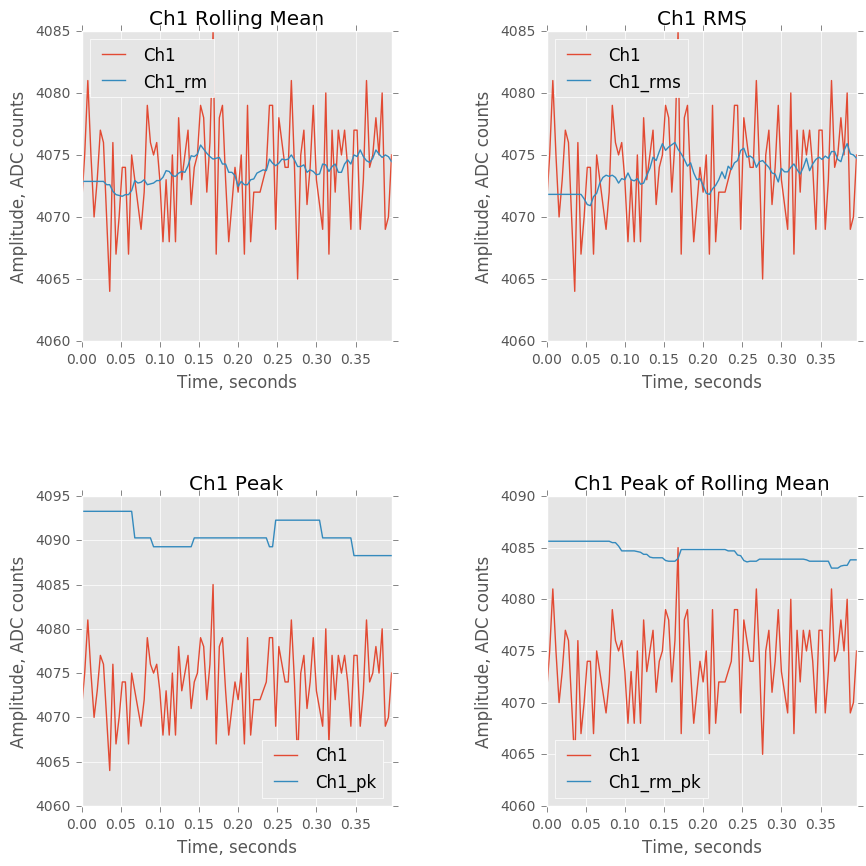

In [18]:
plotFeatures(dfDataTrain.loc[dfDataTrain['Surface'] == 'Carpet1'].iloc[:100], strColName="Ch1")

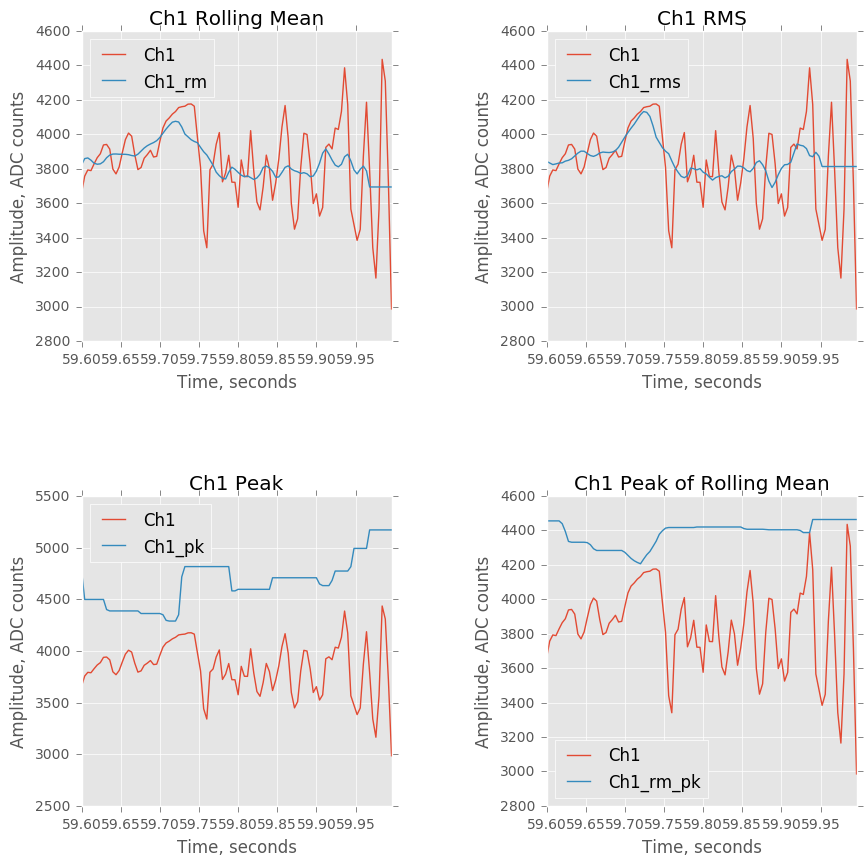

In [19]:
plotFeatures(dfDataTrain.loc[dfDataTrain['Surface'] == 'Carpet1'].tail(100), strColName="Ch1")

### Plot out the carpet data. This surface was compliant so this should have lowest overall amplitudes. I also plotted the light sensor data, but it is not used in the classification. Each plot shows the acquired data (red line), the rolling mean value (blue line), and the peak value (purple line)

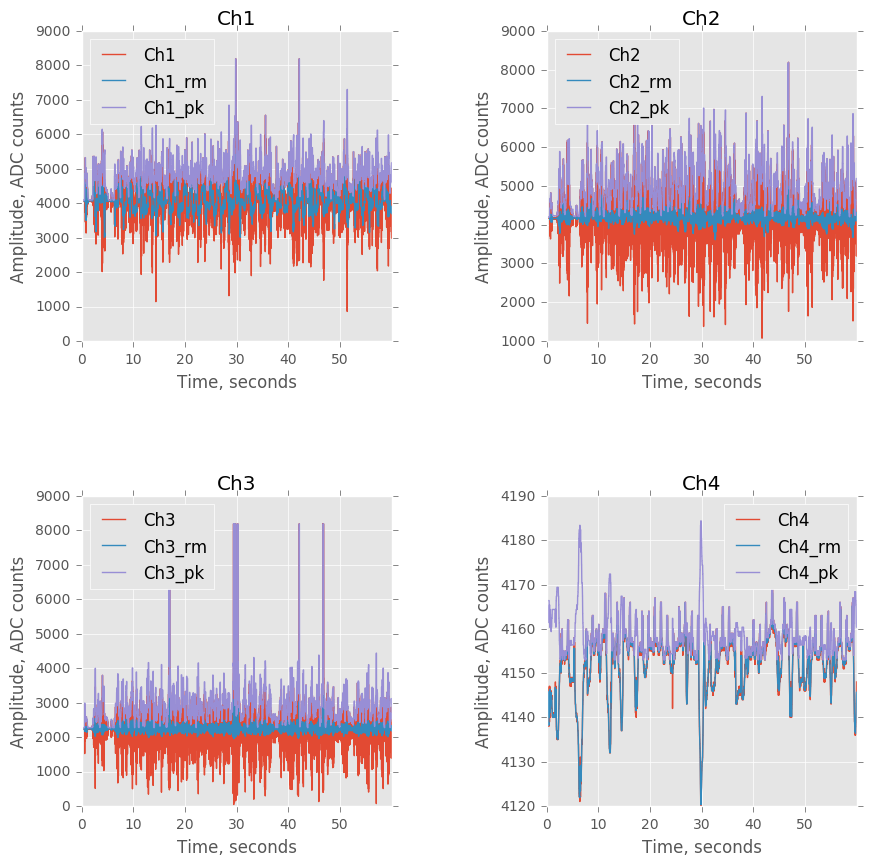

In [20]:
plotFolder(dfDataTrain.loc[dfDataTrain['Surface'] == 'Carpet1'])
plt.savefig("Carpet1Timebase.pdf", format='pdf')

### Now plot the data from the tile. This surface is harder so there should be higher amplitudes, especially in the vertical direction (channel 3, z-axis)

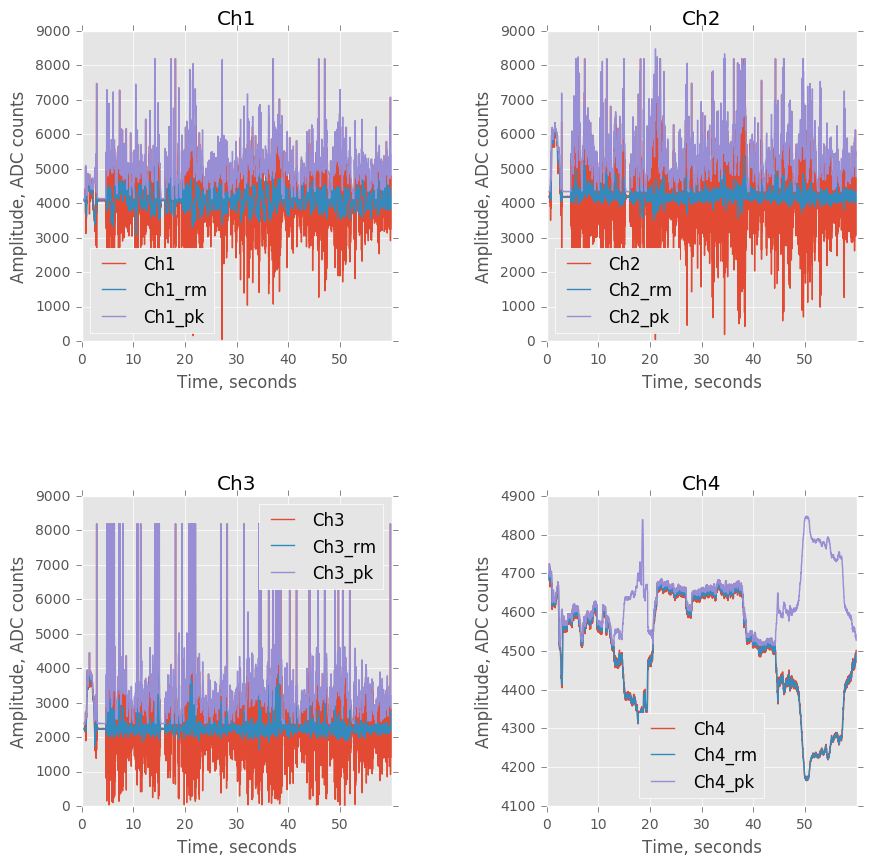

In [21]:
plotFolder(dfDataTrain.loc[dfDataTrain['Surface'] == 'Tile1'])
plt.savefig("Tile1Timebase.pdf", format='pdf')

### Now plot the data from the cobblestorn. This surface is both hard and rough so this has the highest amplitudes.

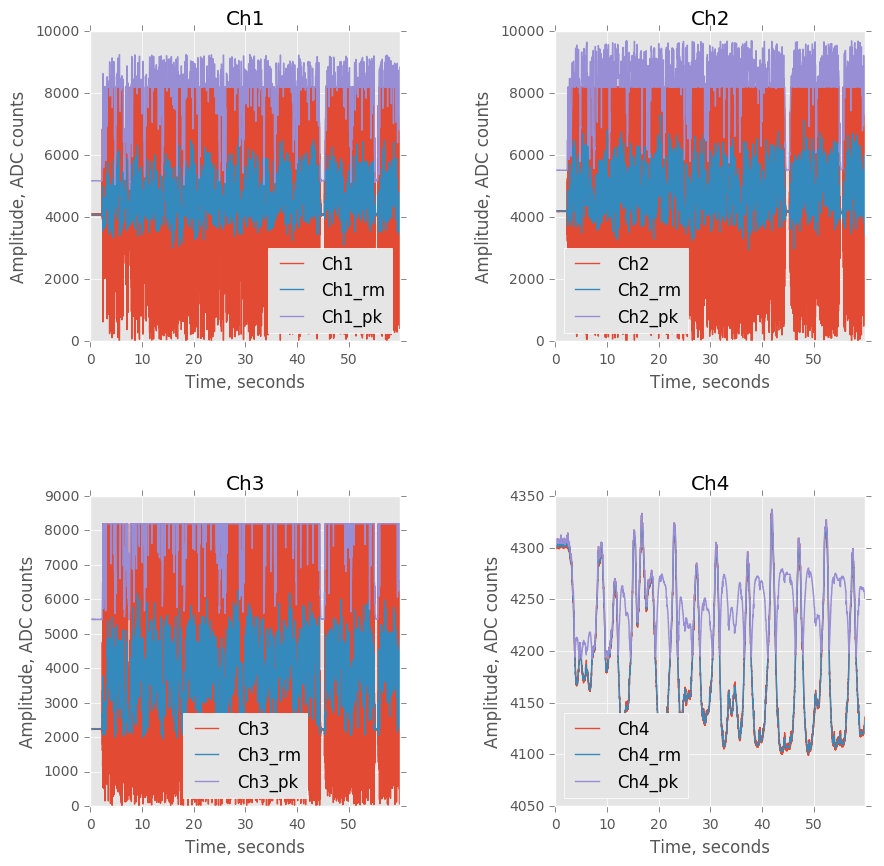

In [22]:
plotFolder(dfDataTrain.loc[dfDataTrain['Surface'] == 'Cobble1'])
plt.savefig("Cobble1Timebase.pdf", format='pdf')

### Next, the distributions of the features are plotted on top of each other. In an ideal world, each of the 3 cases (tile, care, and cobblestone) would be far apart. In the real world it won't be that be clear. This section shows the histograms for the raw signal. The accel signals are all right on top of each other. Ch4 is the light sensor, which doesn't really play in this project.

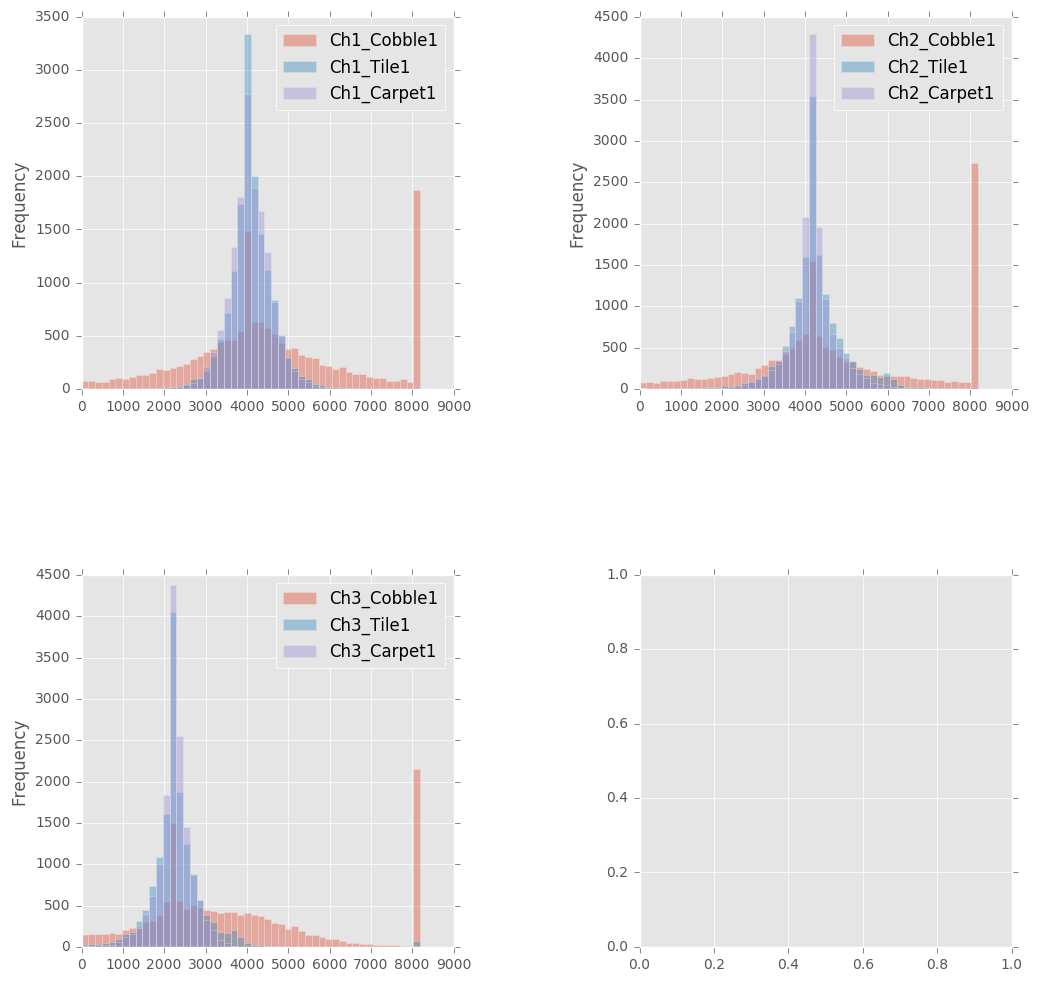

In [23]:
strSuff = ''
plotClasses(dfDataTrain, strSuff)

### This is the rolling mean ('rm') data. The cobble histogram is moving away from the tile and carpet, but not enough.

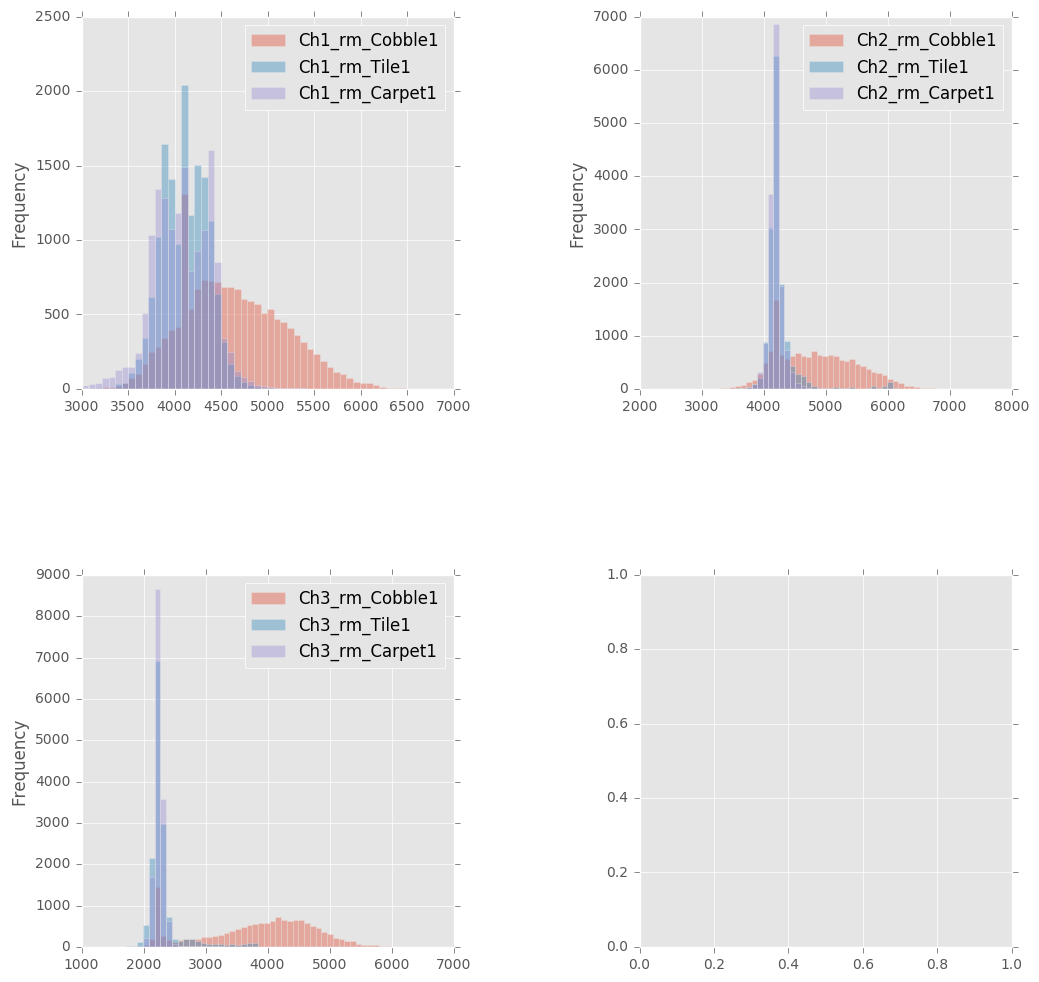

In [24]:
strSuff = 'rm_'
plotClasses(dfDataTrain, strSuff)

### RMS is getting better separation, but that darn tile and carpet are still together.

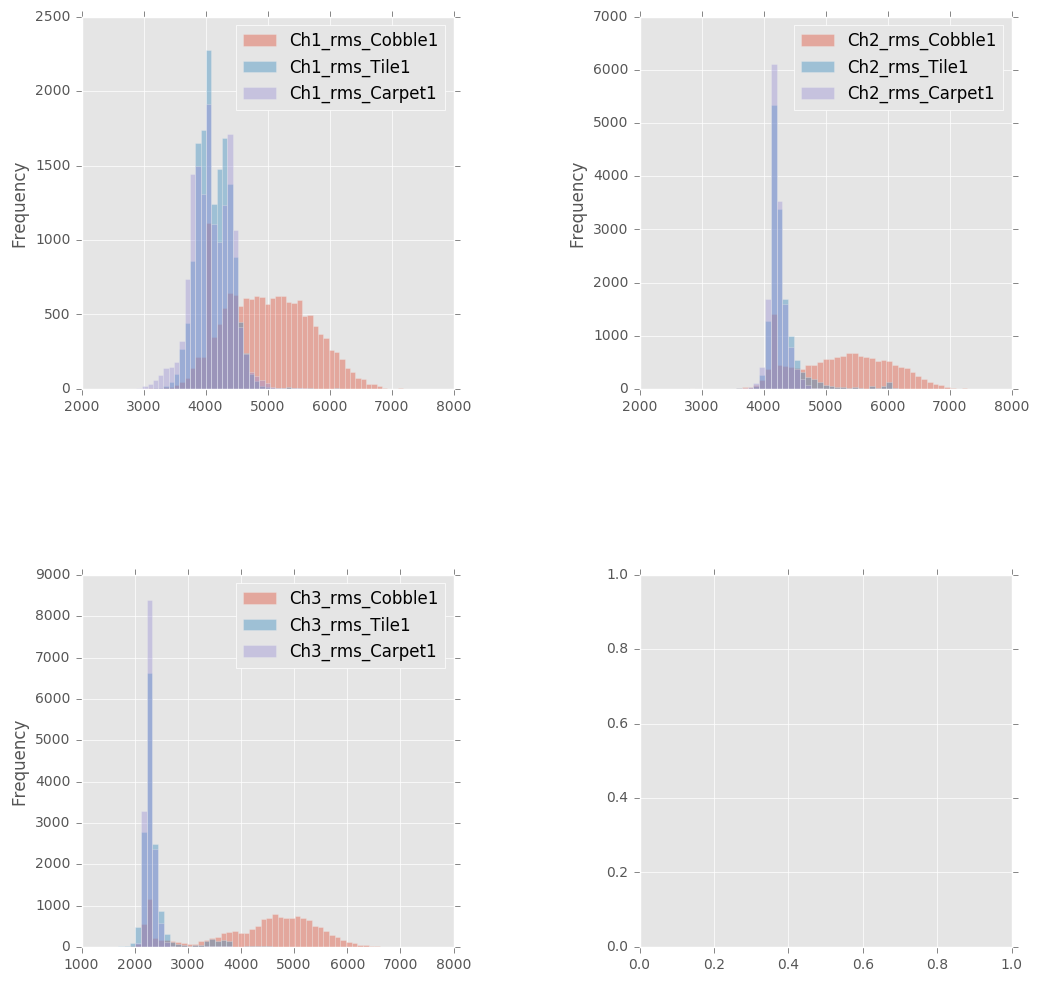

In [25]:
strSuff = 'rms_'
plotClasses(dfDataTrain, strSuff)

### Same for the RMS of the rolling mean

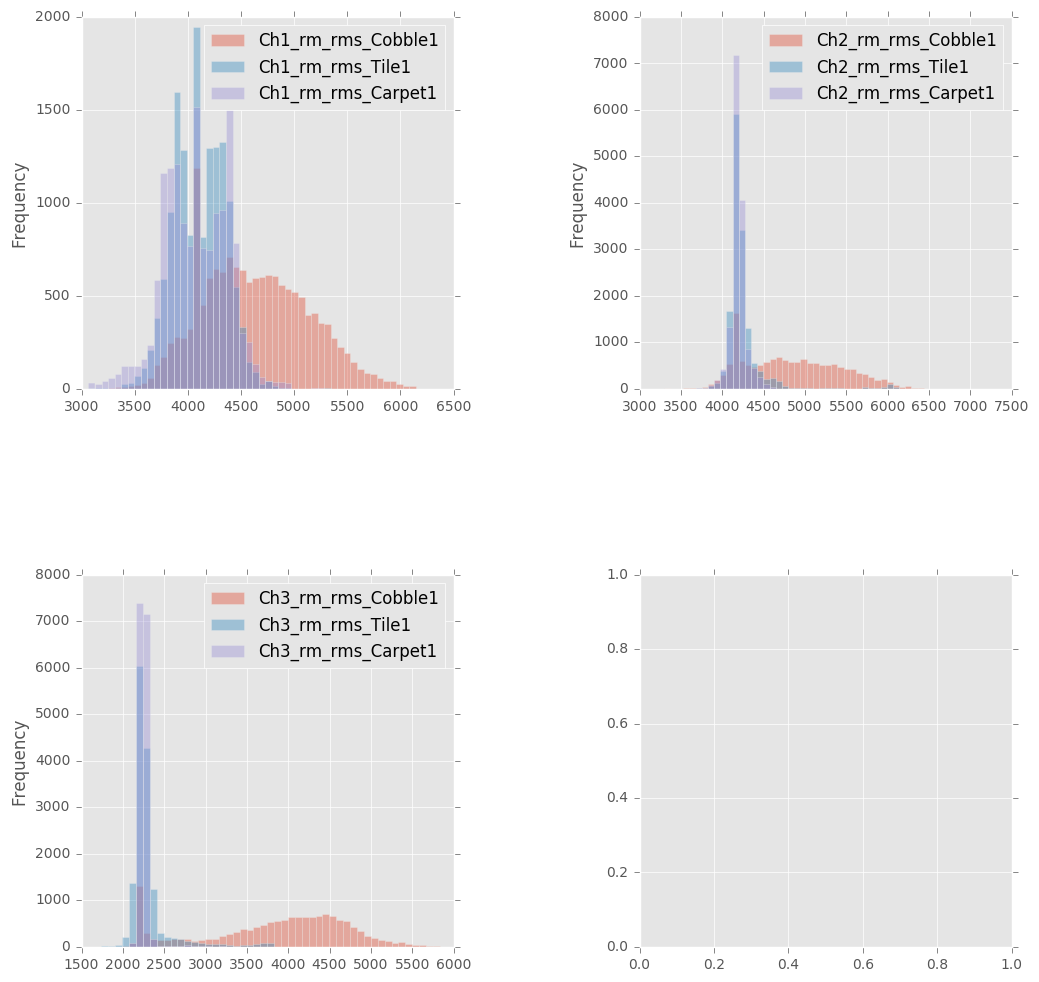

In [26]:
strSuff = 'rm_rms_'
plotClasses(dfDataTrain, strSuff)

### With the peak feature, there is finally some separation of the tile and carpet.

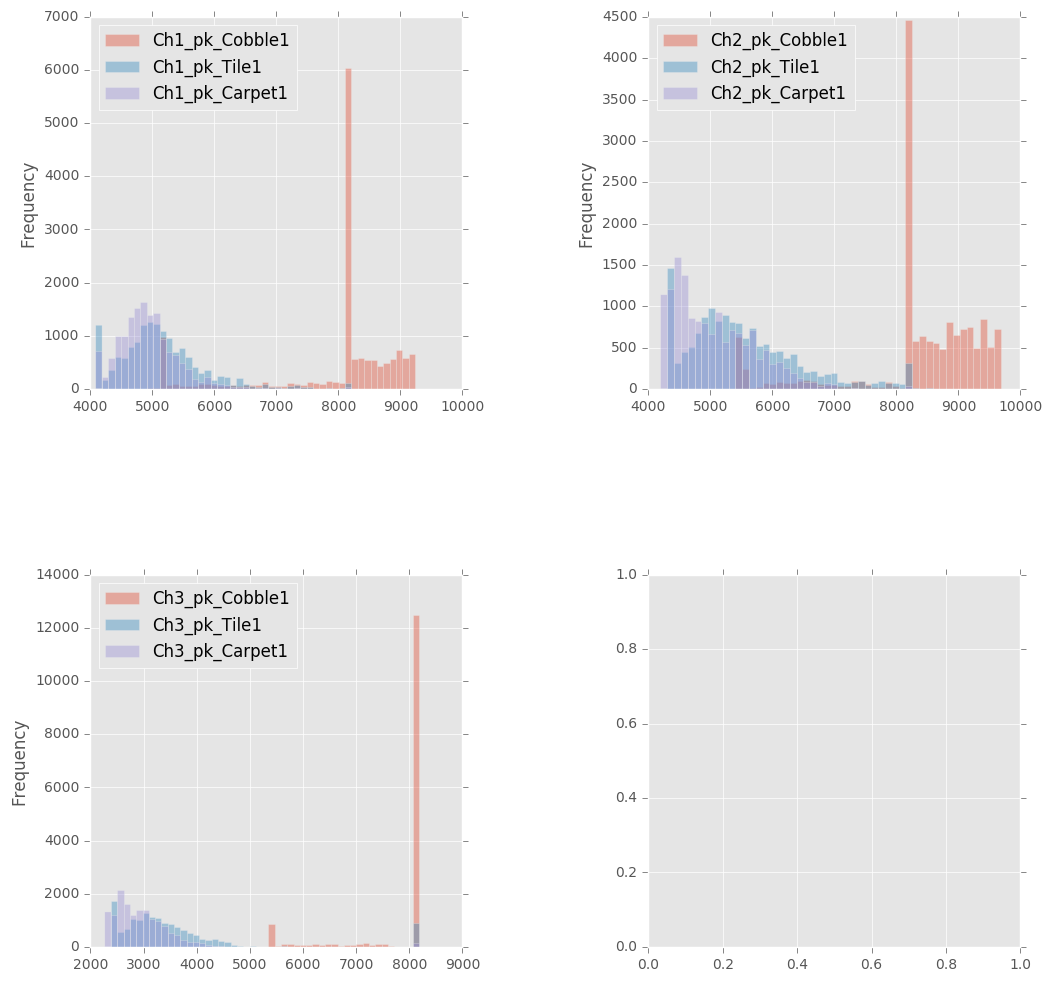

In [27]:
strSuff = 'pk_'
plotClasses(dfDataTrain, strSuff)

### The peak value of the rolling mean gives us the best separation so far.

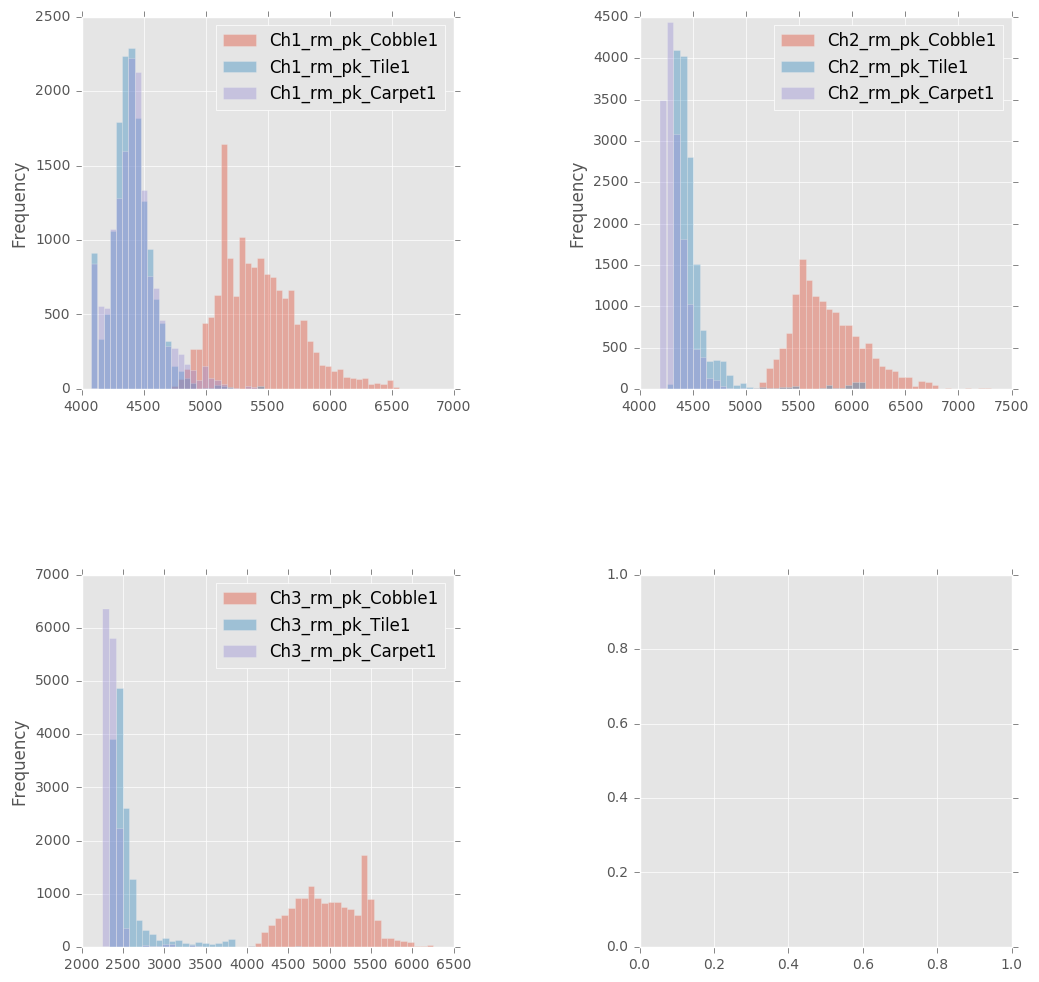

In [28]:
strSuff = 'rm_pk_'
plotClasses(dfDataTrain, strSuff)

### The last try is crest factor (peak/rms) and it doesn't have the separation we need. Looks like we will be going with the peak value of the rolling mean.

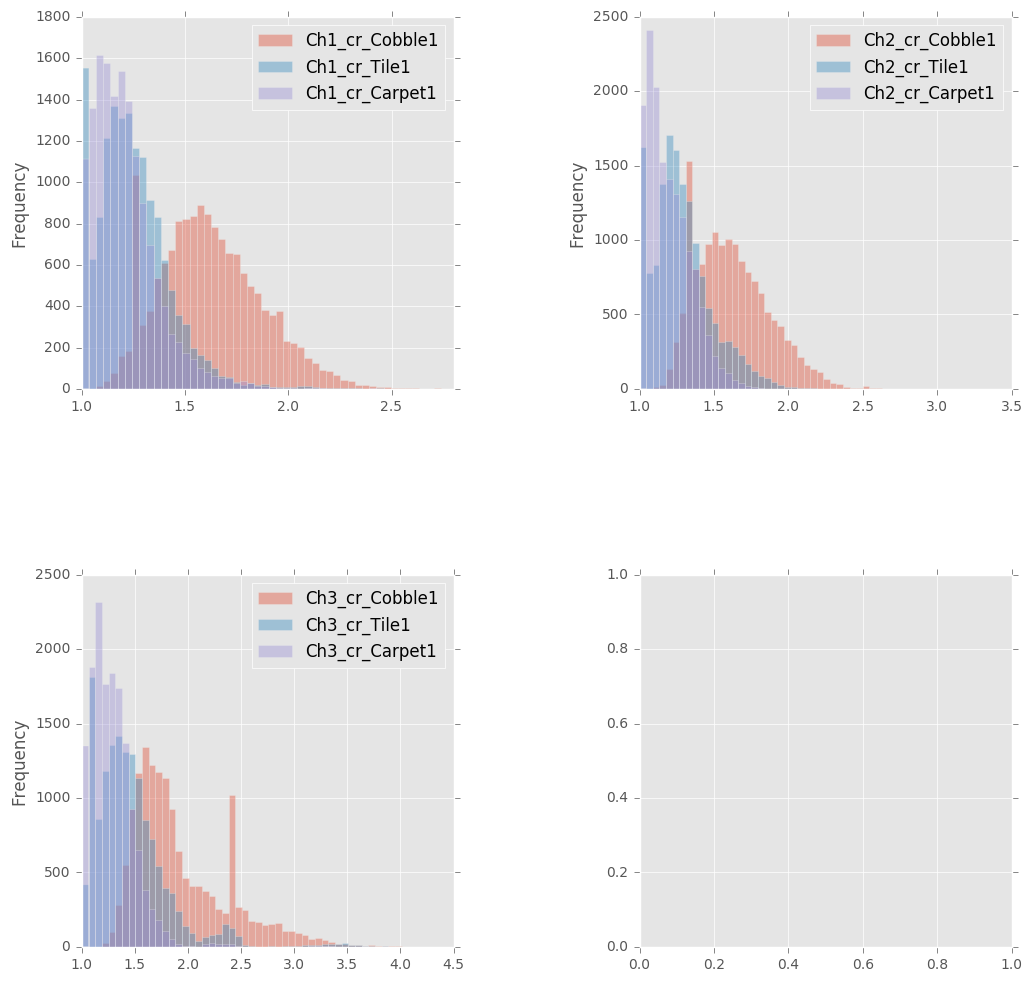

In [29]:
strSuff = 'cr_'
plotClasses(dfDataTrain, strSuff)

# Classification
## Start by plotting out the data. I found these links helpful: http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html and http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html

In [30]:
from sklearn import svm, datasets
import sklearn.ensemble as ens
import sklearn.tree as trees
import pydotplus as pdot
from sklearn.metrics import confusion_matrix
from IPython.display import Image

### This function defines a nice way to visualize the confusion matrix. From scikit-learn documentation: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [31]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### This sections selects the data and randomizes the order. I didn't normalize the data (subtract the mean and divide by the standard deviation), but that might improve the model.

In [32]:
# For testing of the code we want the same seed
RANDOM_SEED = 1024

# select our data
lstFeatures = ['Ch2_rm_pk','Ch3_rm_pk']
lstClassifiers = ['Tile1','Cobble1','Carpet1']
TrainFeatures = dfDataTrain[lstFeatures]
TrainClasses = dfDataTrain['Surface']
TestFeatures = dfDataTest[lstFeatures]
TestClasses = dfDataTrain['Surface']

# Shuffle the data
idx = np.arange(TrainFeatures.shape[0])
np.random.seed(RANDOM_SEED)
np.random.shuffle(idx)
TrainFeatures = TrainFeatures.ix[idx]
TrainClasses = TrainClasses.ix[idx]
TestFeatures = TestFeatures.ix[idx]
TestClasses = TestClasses.ix[idx]

### In this section we will fit the data and plot the model. We are going to use "Decision Trees" because they are simple and perform well with non-linear data (refer to http://scikit-learn.org/stable/modules/tree.html#tree for more details on decision trees). We sacrifice some accuracy in the model, but I wanted something that could be implemented in the Arduino.
### We are going to start with a simple tree, only 2 levels deep

In [33]:
# Configure the decision tree and perform the fit
dtTrain = trees.DecisionTreeClassifier(max_depth=2)
dtTrain = dtTrain.fit(TrainFeatures, TrainClasses)

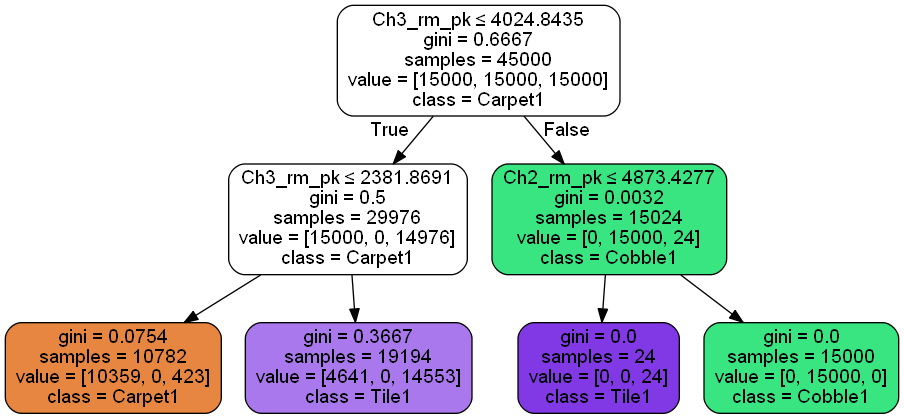

In [34]:
# If you haven't installed "graphviz" you will need to do that.
# I had to infer the ordering of the classifiers and manually
# input them. There's must a better way.
dotData = trees.export_graphviz(dtTrain, out_file='None.dot',
                         feature_names=lstFeatures,  
                         class_names=[lstClassifiers[2], lstClassifiers[1], lstClassifiers[0]],  
                         filled=True, rounded=True,  
                         special_characters=True)
dtGraph = pdot.graph_from_dot_file('None.dot')
Image(dtGraph.create_png())

### The model results can also be summarized in something called a confusion matrix. The matrix has the correct results on the diagonals so you want these values to be high. For our fit, the diagonals are high and the off-diagonal terms are small. This is not a bad model so far.

Confusion matrix, without normalization
[[14577     0  4641]
 [    0 15000     0]
 [  423     0 10359]]


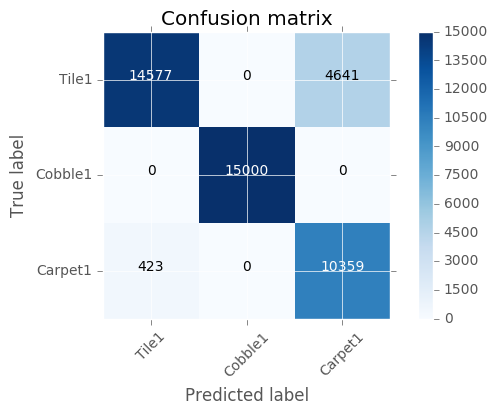

In [35]:
predTrainClasses = dtTrain.predict(TrainFeatures)
cnm= confusion_matrix(predTrainClasses, TrainClasses, labels=lstClassifiers)
plot_confusion_matrix(cnm, lstClassifiers)

### The better indicator of performance will be on the test data. We still have high values in the diagonal terms, but there are also higher values in the off-diagonal terms. 

Confusion matrix, without normalization
[[12186  1892  4447]
 [   63 13108     0]
 [ 2751     0 10553]]


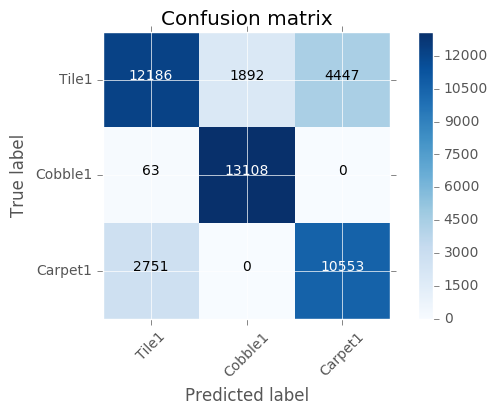

In [36]:
predTestClasses = dtTrain.predict(TestFeatures)
cnm= confusion_matrix(predTestClasses, TestClasses, labels=lstClassifiers)
plot_confusion_matrix(cnm, lstClassifiers)

### Plot the data out. When possible, I like to see how the model and data interact. One way to do this is put the model on a contour plot and overlay it with the data. That's what we are going to do in this section

In [37]:
# mesh for the features
h=1
x_min, x_max = TrainFeatures[lstFeatures[0]].min() - 1, TrainFeatures[lstFeatures[0]].max() + 1
y_min, y_max = TrainFeatures[lstFeatures[1]].min() - 1, TrainFeatures[lstFeatures[1]].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

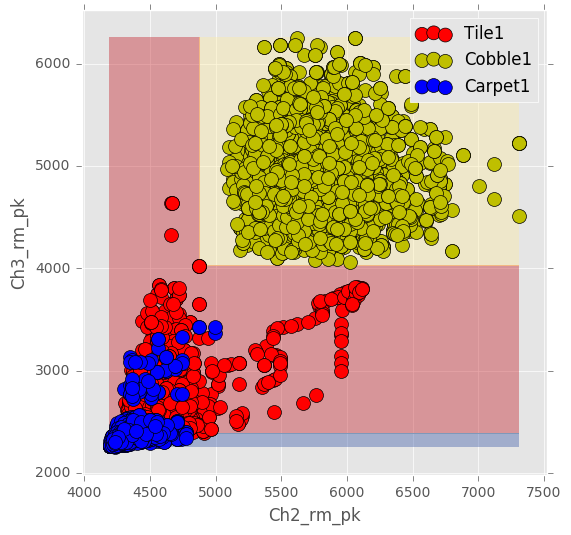

In [38]:
plot_colors = "ryb"
cmapIn = plt.cm.RdYlBu
iClassifiers = len(lstClassifiers)

plt.figure(num=None, figsize=(6, 6))
Z = dtTrain.predict(np.c_[xx.ravel(), yy.ravel()])
dctTemp = {lstClassifiers[0]:0, lstClassifiers[1]:1, lstClassifiers[2]:2}
Zt = np.zeros_like(Z)
for idx in range(0,len(Z)):
    Zt[idx] = dctTemp[Z[idx]]
Zt = Zt.reshape(xx.shape)
cs = plt.contourf(xx, yy, Zt, cmap=cmapIn, alpha=0.4)

for i, cIn in zip(xrange(iClassifiers), plot_colors):
    idx = np.where(TrainClasses==lstClassifiers[i])[0]
    plt.scatter(TrainFeatures.iloc[idx[1:3500],0], TrainFeatures.iloc[idx[1:3500],1], label=lstClassifiers[i], cmap=cmapIn, 
                c=cIn, edgecolor='black', s=100)
plt.legend()
plt.xlabel(lstFeatures[0])
plt.ylabel(lstFeatures[1])
plt.savefig("Scatter.pdf", format='pdf')

### It is tempting to try to improve the model by adding complexity. So let's try an experiment and add another layer to our decision tree. We'll begin by building another model and test it.

In [39]:
# Configure the decision tree and perform the fit
dtTrain3 = trees.DecisionTreeClassifier(max_depth=3)
dtTrain3 = dtTrain3.fit(TrainFeatures, TrainClasses)

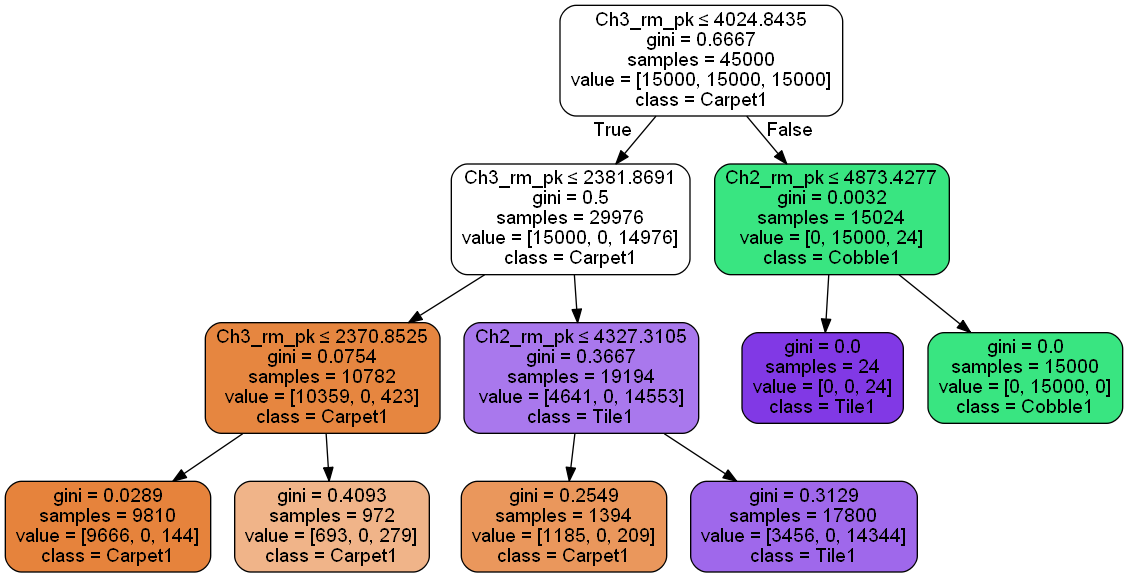

In [40]:
dotData3 = trees.export_graphviz(dtTrain3, out_file='None3.dot',
                         feature_names=lstFeatures,  
                         class_names=[lstClassifiers[2], lstClassifiers[1], lstClassifiers[0]],  
                         filled=True, rounded=True,  
                         special_characters=True)
dtGraph3 = pdot.graph_from_dot_file('None3.dot')
Image(dtGraph3.create_png())

### We got the additional layer we wanted, but how does the performance look? We'll begin by looking at the confusion matrix for the training data.

Confusion matrix, without normalization
[[14368     0  3456]
 [    0 15000     0]
 [  632     0 11544]]


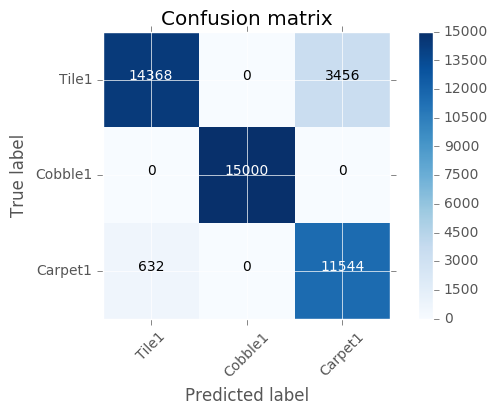

In [41]:
predTrainClasses3 = dtTrain3.predict(TrainFeatures)
cnm= confusion_matrix(predTrainClasses3, TrainClasses, labels=lstClassifiers)
plot_confusion_matrix(cnm, lstClassifiers)

### The model improved, especially in differentiating the tile and carpeted surface. As mentioned before, the real proof will be on the test data

Confusion matrix, without normalization
[[ 7732  1892  3430]
 [   63 13108     0]
 [ 7205     0 11570]]


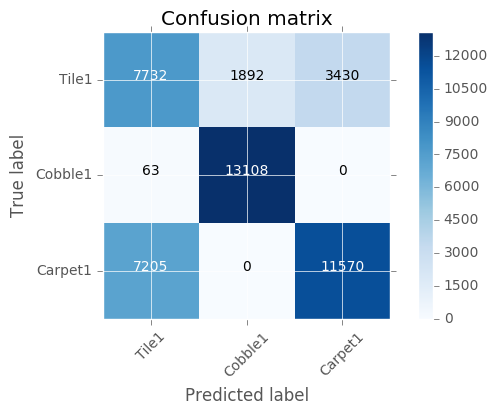

In [42]:
predTestClasses3 = dtTrain3.predict(TestFeatures)
cnm= confusion_matrix(predTestClasses3, TestClasses, labels=lstClassifiers)
plot_confusion_matrix(cnm, lstClassifiers)

### That didn't work out very well at all on the test data, especially on the tile and carpet. This is a great example of overfitting. The model is so complex that it has adapted very well to the training data, but that makes it ill suited for the test data.

# Conclusion

### Looks like we have a valid model for road surface detection. In a future step of the project we will implement the model on the Arduino, then take the car for a drive to see how well the Arduino can tell what the surface is.